# ***Website Traffic Forecasting***

# ***Table of Contents***

1. Introduction

 * Project overview and objectives
2. Dataset Overview

 * Dataset description and summary statistics

3. Data Preprocessing

 * Data cleaning and transformation steps

4. Modeling Approach

 * Description of forecasting models used

5. Model Evaluation

 * Performance metrics for model comparison

6. Results and Visualizations

 * Plots of actual vs. forecasted values and model comparisons

7. Conclusion

 * Summary of findings and project implications


# ***Introduction***

 * This project focuses on forecasting website traffic to support better resource allocation and planning. By using historical traffic data, we aim to predict future trends, providing valuable insights for managing web server resources and enhancing user experience. The approach includes implementing multiple time series forecasting models and visualizing the forecasted results alongside actual data to evaluate model performance. These forecasts can assist in anticipating peak usage periods, ensuring efficient website operations, and enabling proactive decision-making.



In [ ]:
!pip install statsforecast

In [ ]:
!pip install datasetsforecast

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsforecast import StatsForecast
from statsforecast.models import MSTL,AutoARIMA, SeasonalNaive, TBATS,OptimizedTheta,SeasonalExponentialSmoothingOptimized
import seaborn as sns
from datasetsforecast.losses import (
    mae, mape, mase, rmse, smape
)
import warnings
warnings.filterwarnings('ignore')

[StatsForecast](https://nixtlaverse.nixtla.io/statsforecast/index.html)

In [ ]:
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
dark_style = {
    'figure.facecolor': '#212946',
    'axes.facecolor': '#212946',
    'savefig.facecolor':'#212946',
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False,
    'grid.color': '#2A3459',
    'grid.linewidth': '1',
    'text.color': '0.9',
    'axes.labelcolor': '0.9',
    'xtick.color': '0.9',
    'ytick.color': '0.9',
    'font.size': 12 }
plt.rcParams.update(dark_style)

from pylab import rcParams
rcParams['figure.figsize'] = (18,10)

In [ ]:
df = pd.read_csv('/content/daily-website-visitors.csv')

In [ ]:
df.head()

,Row,Day,Day.Of.Week,Date,Page.Loads,Unique.Visits,First.Time.Visits,Returning.Visits
0,1,Sunday,1,9/14/2014,"2,146","1,582","1,430",152
1,2,Monday,2,9/15/2014,"3,621","2,528","2,297",231
2,3,Tuesday,3,9/16/2014,"3,698","2,630","2,352",278
3,4,Wednesday,4,9/17/2014,"3,667","2,614","2,327",287
4,5,Thursday,5,9/18/2014,"3,316","2,366","2,130",236


In [ ]:
df.shape

(2167, 8)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2167 entries, 0 to 2166
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Row                2167 non-null   int64 
 1   Day                2167 non-null   object
 2   Day.Of.Week        2167 non-null   int64 
 3   Date               2167 non-null   object
 4   Page.Loads         2167 non-null   object
 5   Unique.Visits      2167 non-null   object
 6   First.Time.Visits  2167 non-null   object
 7   Returning.Visits   2167 non-null   object
dtypes: int64(2), object(6)
memory usage: 135.6+ KB


In [ ]:
df.columns = [col.replace(".","_") for col in df.columns]

In [ ]:
df["Date"] = pd.to_datetime(df["Date"])
df["Page_Loads"] = df["Page_Loads"].replace(",", "",regex=True).astype("int16")
df["Unique_Visits"] = df["Unique_Visits"].replace(",", "",regex=True).astype("int16")
df["Day_Of_Week"] = df["Day_Of_Week"].astype("int16")
df["First_Time_Visits"] = df["First_Time_Visits"].str.replace(",", "",regex=True).astype("int16")
df["Returning_Visits"] = df["Returning_Visits"].str.replace(",", "",regex=True).astype("int16")
df.drop(columns="Row",inplace=True)

In [ ]:
df.describe()

,Day_Of_Week,Date,Page_Loads,Unique_Visits,First_Time_Visits,Returning_Visits
count,2167.000000,2167,2167.000000,2167.000000,2167.000000,2167.000000
mean,3.997231,2017-09-01 00:00:00,4116.989386,2943.646516,2431.824181,511.822335
min,1.000000,2014-09-14 00:00:00,1002.000000,667.000000,522.000000,133.000000
25%,2.000000,2016-03-08 12:00:00,3114.500000,2226.000000,1830.000000,388.500000
50%,4.000000,2017-09-01 00:00:00,4106.000000,2914.000000,2400.000000,509.000000
75%,6.000000,2019-02-24 12:00:00,5020.500000,3667.500000,3038.000000,626.500000
max,7.000000,2020-08-19 00:00:00,7984.000000,5541.000000,4616.000000,1036.000000
std,2.000229,NaN,1350.977843,977.886472,828.704688,168.736370


In [ ]:
df.drop(columns="Day",inplace=True)

In [ ]:
df.drop(columns="Day_Of_Week",inplace=True)

In [ ]:
df.set_index("Date",inplace=True)
df.sort_index(inplace=True)

In [ ]:
df_pl = df[["Page_Loads"]]
df_uv = df[["Unique_Visits"]]
df_ftv = df[["First_Time_Visits"]]
df_rv = df[["Returning_Visits"]]

In [ ]:
df_pl.head()

,Page_Loads
Date,
2014-09-14,2146
2014-09-15,3621
2014-09-16,3698
2014-09-17,3667
2014-09-18,3316


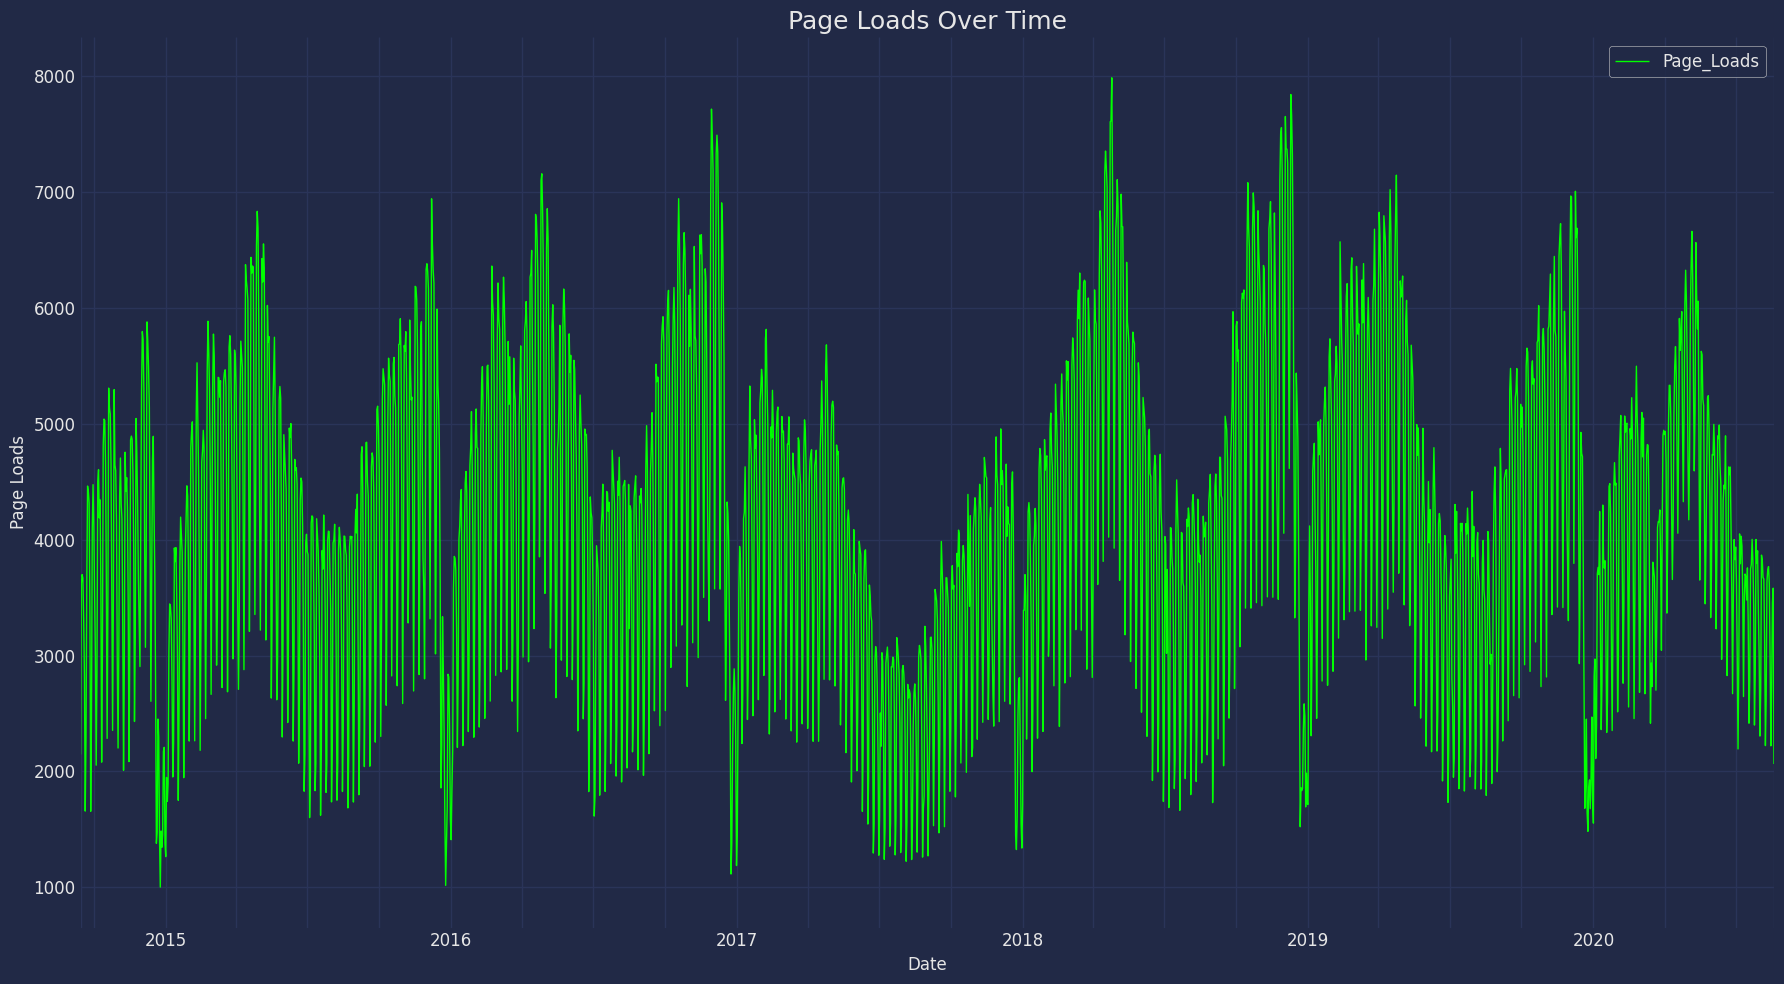

In [ ]:
fig, ax = plt.subplots(figsize=(18, 10))
df_pl.plot(ax=ax, color="lime", linestyle="-", linewidth=1, markersize=8)

ax.set_title("Page Loads Over Time", fontsize=18)
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Page Loads", fontsize=12)
fig.tight_layout()
plt.show()

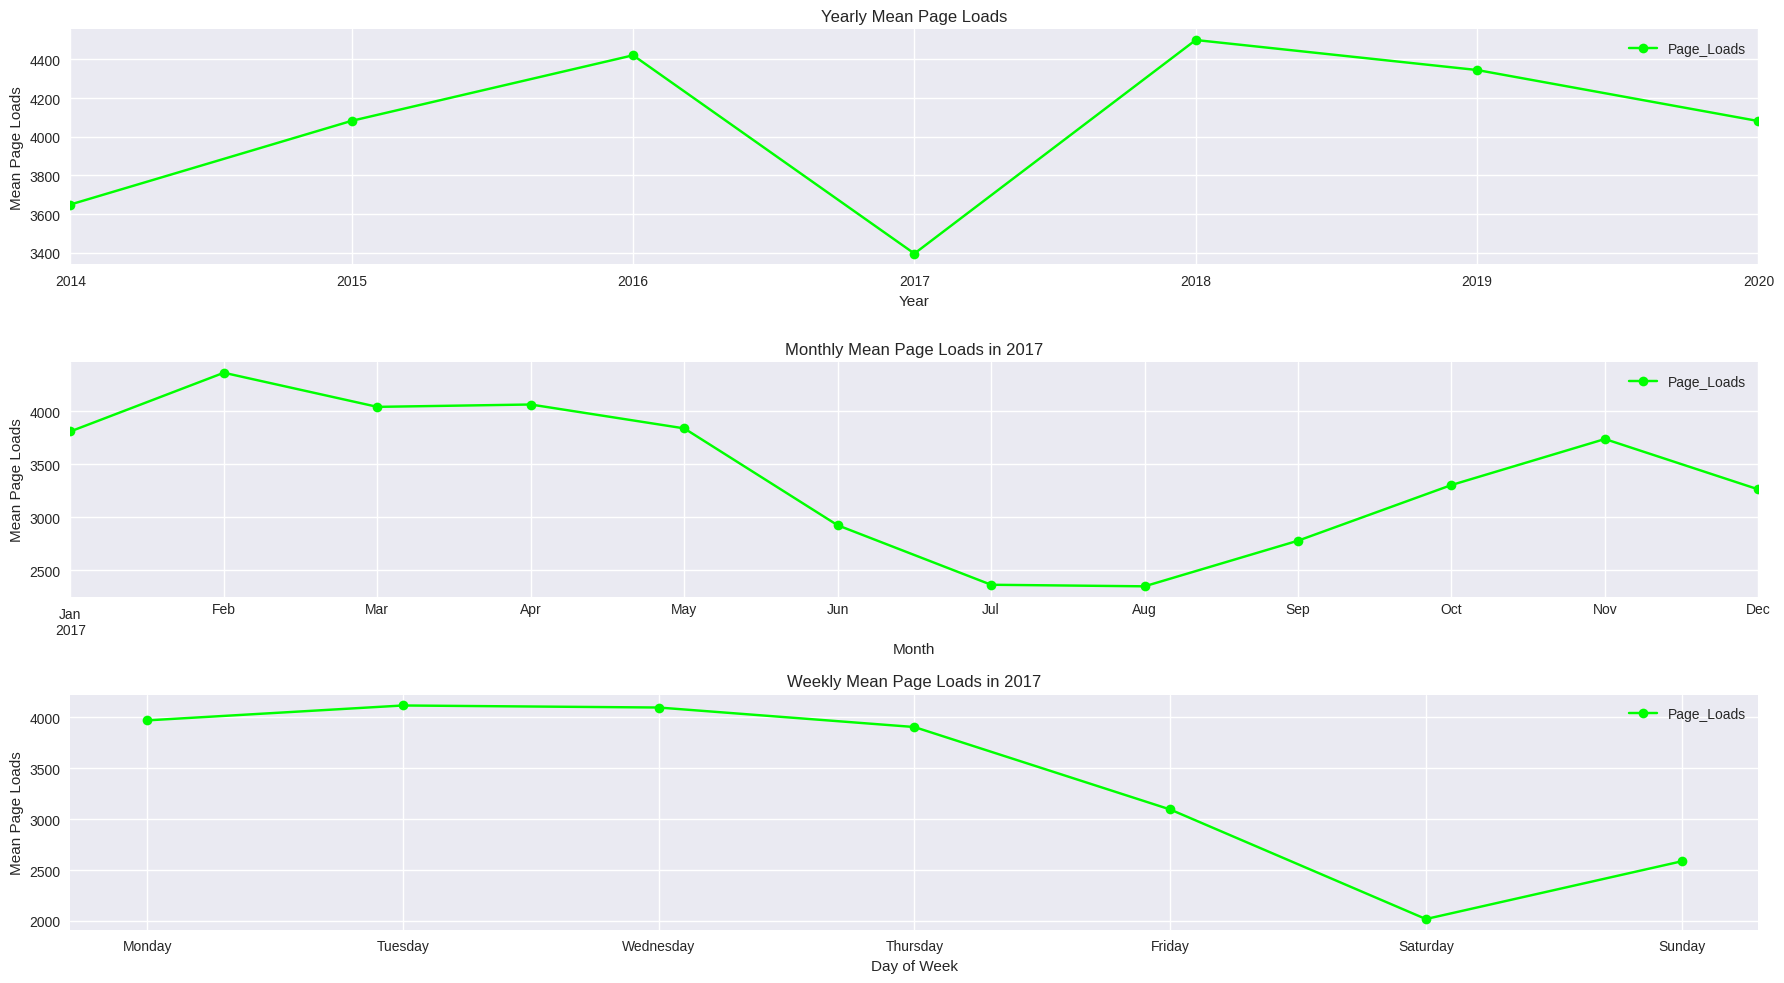

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(18, 10))
df_pl.resample("YE").mean().plot(marker="o", color="lime", ax=axes[0])
axes[0].set_title("Yearly Mean Page Loads")
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Mean Page Loads")
df_pl["2017-01":"2017-12"].resample("ME").mean().plot(marker="o", color="lime", ax=axes[1])
axes[1].set_title("Monthly Mean Page Loads in 2017")
axes[1].set_xlabel("Month")
axes[1].set_ylabel("Mean Page Loads")
a = df_pl["2017-01":"2017-12"].groupby(df_pl["2017-01":"2017-12"].index.dayofweek).mean()
a.plot(marker="o", color="lime", ax=axes[2])
axes[2].set_title("Weekly Mean Page Loads in 2017")
axes[2].set_xlabel("Day of Week")
axes[2].set_ylabel("Mean Page Loads")
axes[2].set_xticklabels(df_pl.index.strftime("%A"))
plt.tight_layout()
plt.show()

The input to StatsForecast is always a data frame in long format with three columns: *unique_id*, *ds* and *y*:

In [ ]:
def transform_dataframe(df,target_column):
    df_transformed = df.reset_index()
    df_transformed.rename(columns={"Date": "ds", target_column: "y"}, inplace=True)
    df_transformed["unique_id"] = "1"
    return df_transformed

In [ ]:
df_pl_transformed = transform_dataframe(df_pl,target_column="Page_Loads")

In [ ]:
df_pl_transformed.head()

,ds,y,unique_id
0,2014-09-14,2146,1
1,2014-09-15,3621,1
2,2014-09-16,3698,1
3,2014-09-17,3667,1
4,2014-09-18,3316,1


In [ ]:
from statsmodels.tsa.stattools import adfuller
def Augmented_Dickey_Fuller_Test_func(series , column_name):
    print (f'Dickey-Fuller test results for columns: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Number of observations used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Reject the null hypothesis")
        print("The data is stationary")
    else:
        print("Conclusion:====>")
        print("The null hypothesis cannot be rejected")
        print("The data is not stationary")

In [ ]:
Augmented_Dickey_Fuller_Test_func(df_pl_transformed["y"],"Ads")

Dickey-Fuller test results for columns: Ads
Test Statistic                   -4.283821
p-value                           0.000474
No Lags Used                     26.000000
Number of observations used    2140.000000
Critical Value (1%)              -3.433409
Critical Value (5%)              -2.862892
Critical Value (10%)             -2.567489
dtype: float64
Conclusion:====>
Reject the null hypothesis
The data is stationary


In [ ]:
mstl = MSTL(
    season_length=[7,12],
    trend_forecaster=AutoARIMA()
)

In [ ]:
sf = StatsForecast(
    models=[mstl],
    freq="D",
)

In [ ]:
sf = sf.fit(df=df_pl_transformed)

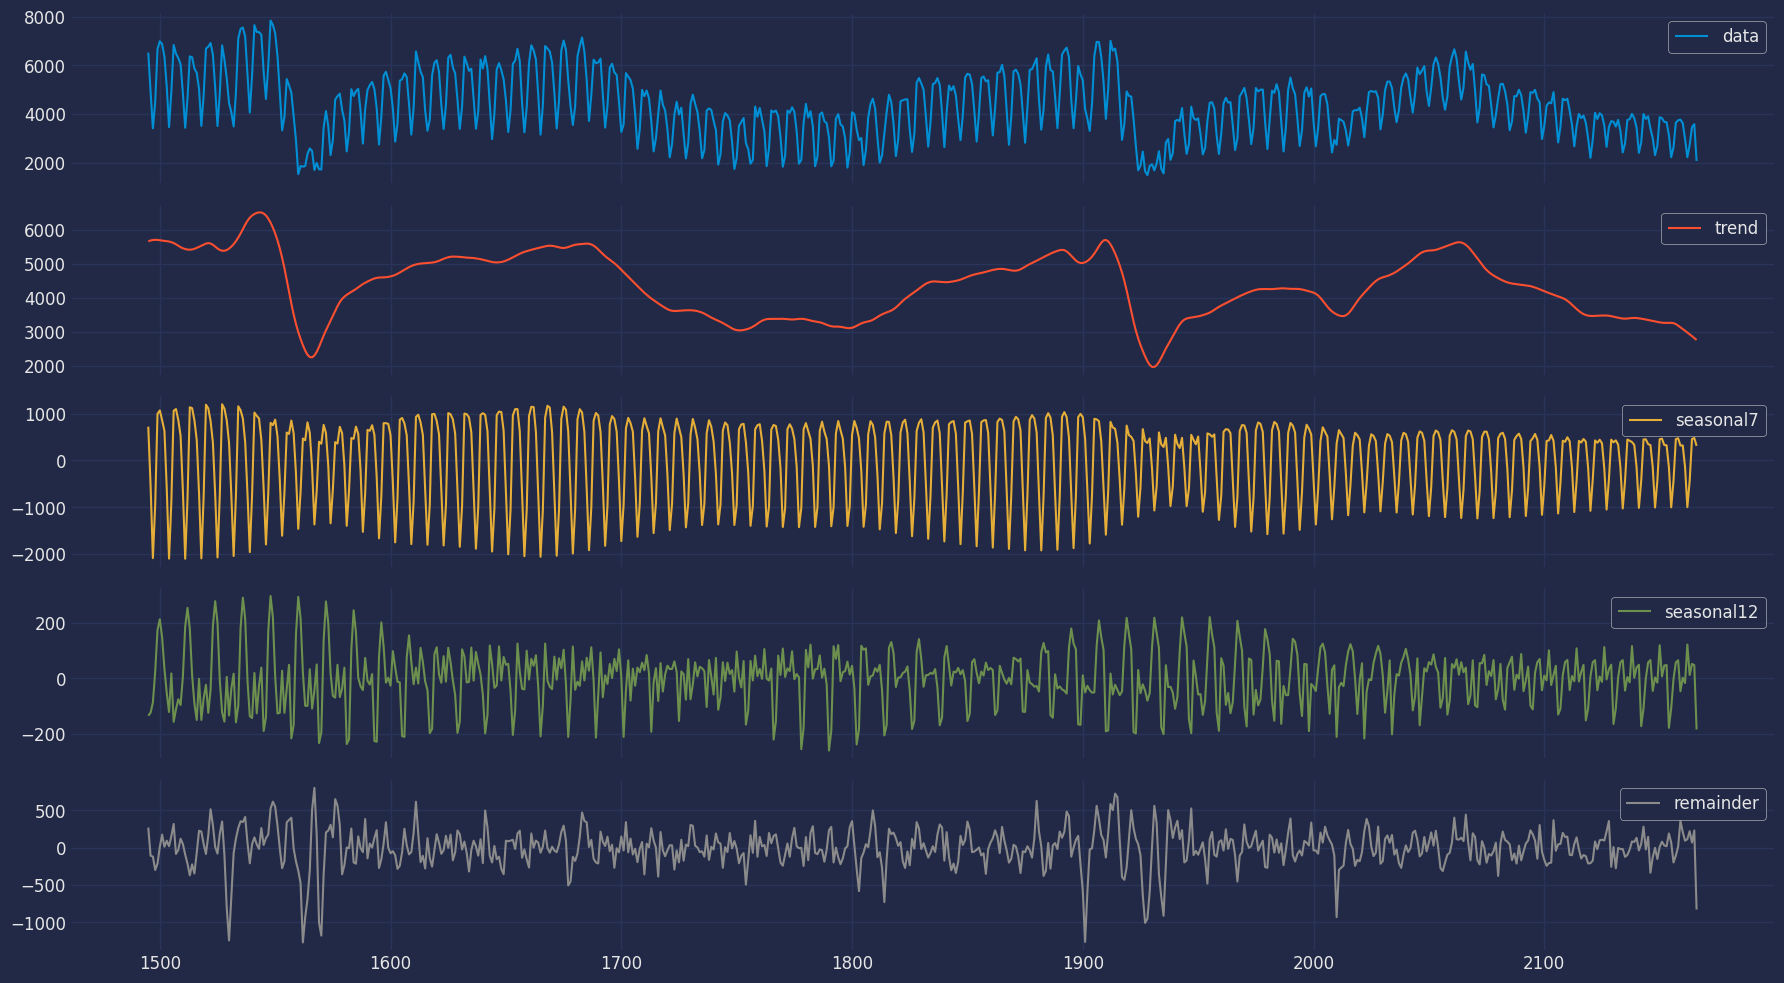

In [ ]:
sf.fitted_[0, 0].model_.tail(24 * 28).plot(subplots=True, grid=True,)
plt.tight_layout()
plt.show()

In [ ]:
def plot_forecasts(y_hist, y_true, y_pred, models,target_name):
    _, ax = plt.subplots(1, 1, figsize = (20, 7))
    y_true = y_true.merge(y_pred, how="left", on=["unique_id", "ds"])
    df_plot = pd.concat([y_hist, y_true]).set_index('ds').tail(30*5)
    df_plot[['y'] + models].plot(ax=ax, linewidth=2)

    ax.set_title(f"{target_name} Daily", fontsize=22)
    ax.set_ylabel(f"{target_name}", fontsize=20)
    ax.set_xlabel("Timestamp [t]", fontsize=20)
    ax.legend(prop={'size': 15})
    ax.grid()


In [ ]:
df_test = df_pl_transformed.tail(30)
df_train = df_pl_transformed.drop(df_test.index)

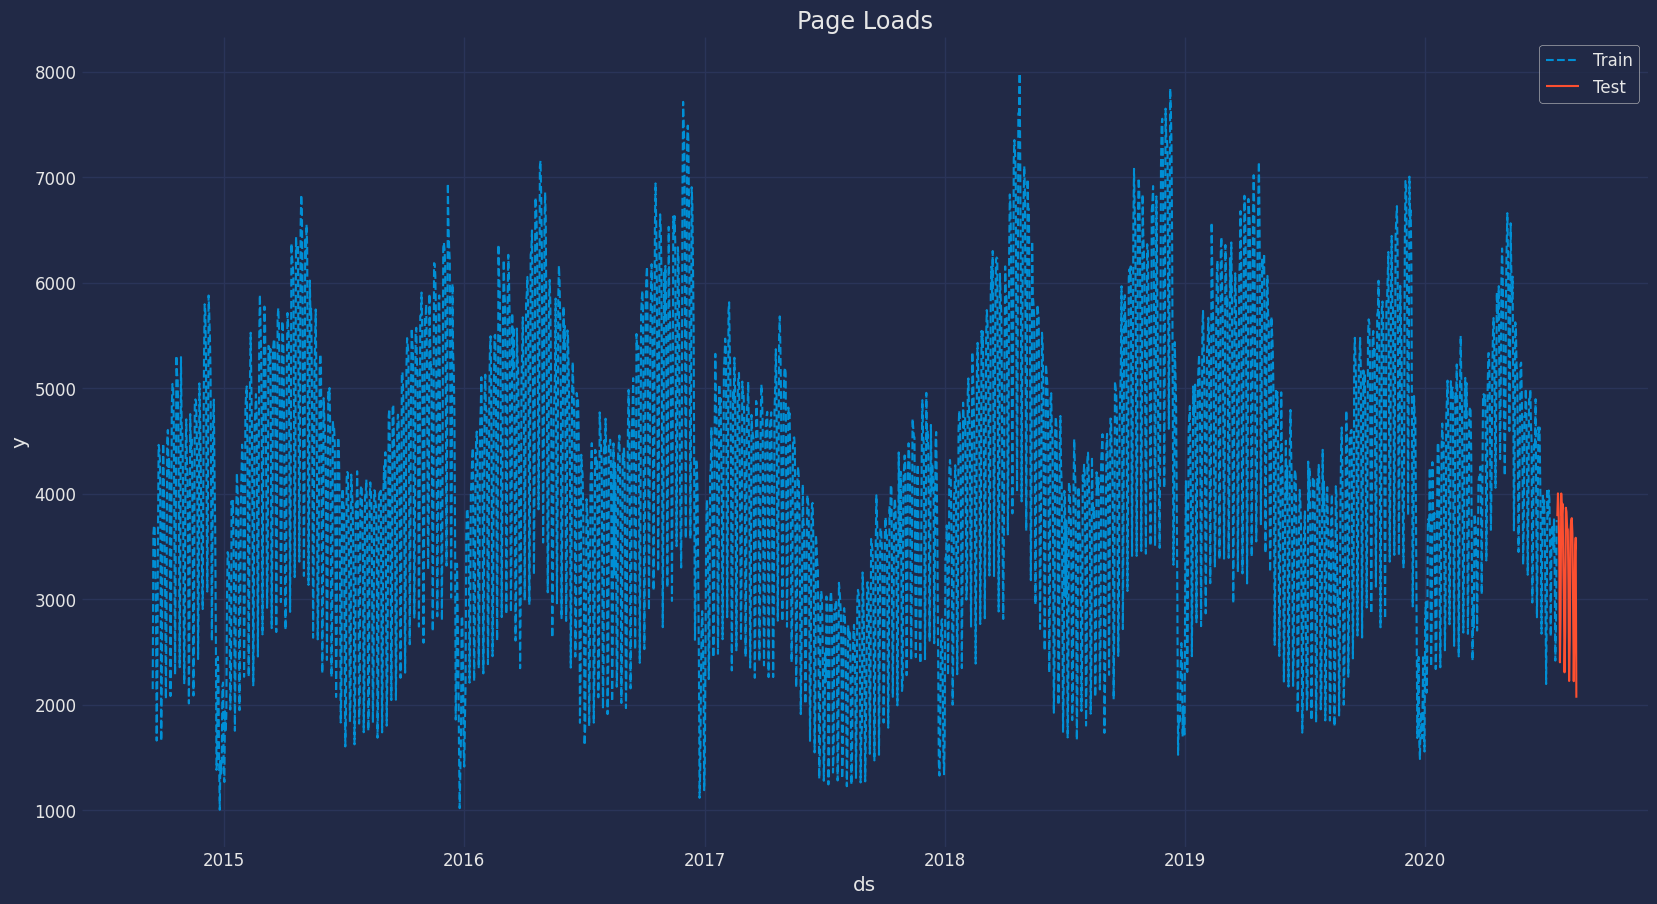

In [ ]:
sns.lineplot(df_train,x="ds", y="y", label="Train", linestyle="--")
sns.lineplot(df_test, x="ds", y="y", label="Test")
plt.title("Page Loads");
plt.show()

In [ ]:
season_length = 7
sf = StatsForecast(
    models=[mstl, SeasonalNaive(season_length=season_length),
            OptimizedTheta(season_length=season_length,decomposition_type="additive"),
            SeasonalExponentialSmoothingOptimized(season_length=season_length),TBATS(seasonal_periods=season_length)
        ],
    freq="D"
)

In [ ]:
sf = sf.fit(df=df_train)
forecasts_test = sf.predict(h=len(df_test))

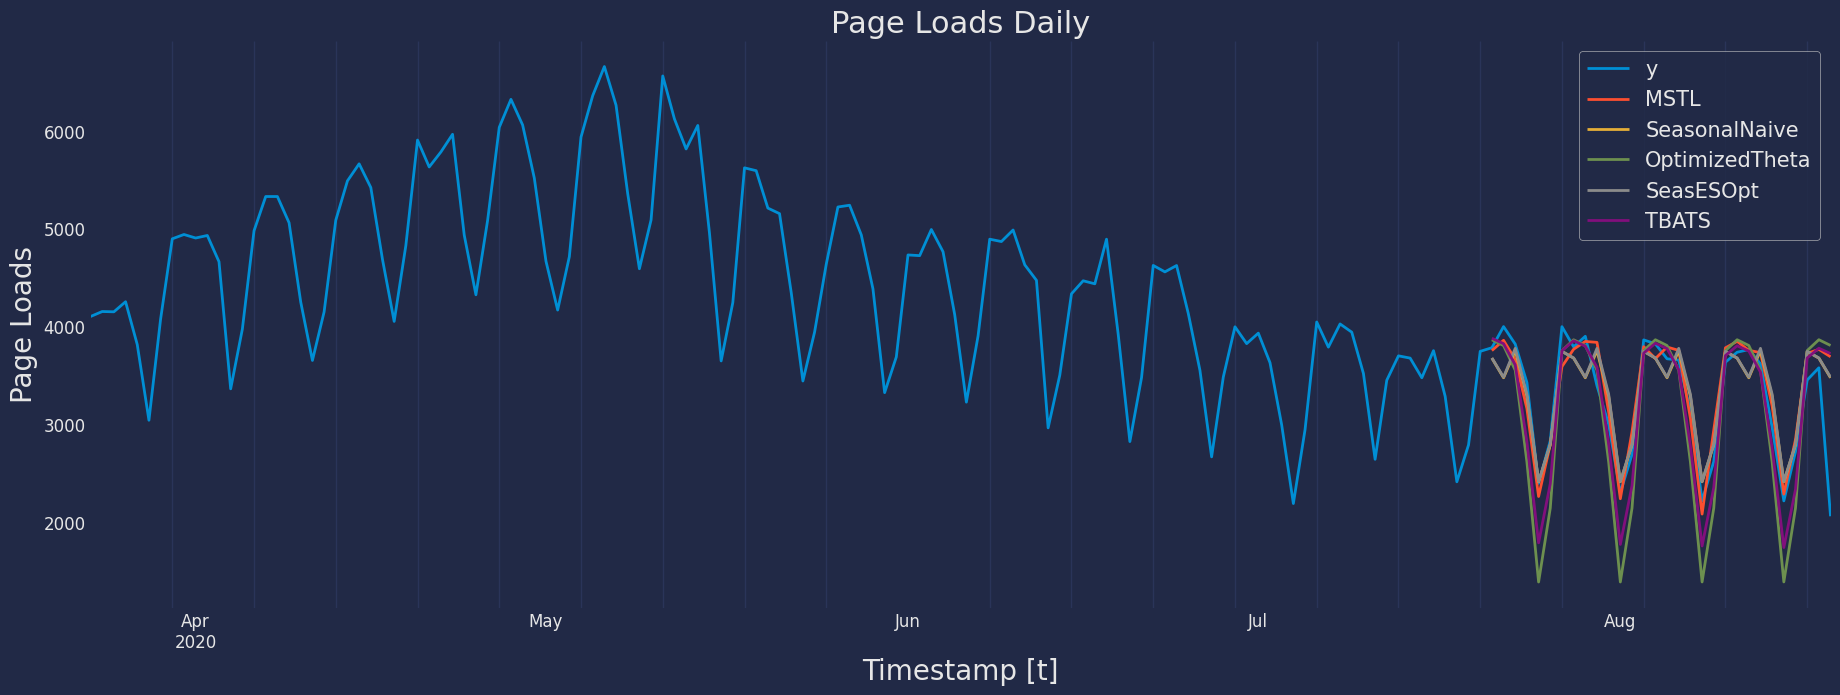

In [ ]:
plot_forecasts(df_train, df_test, forecasts_test, models=["MSTL", "SeasonalNaive","OptimizedTheta","SeasESOpt","TBATS"],target_name="Page Loads")

In [ ]:
StatsForecast.plot(df_pl_transformed,forecasts_test,engine="plotly")

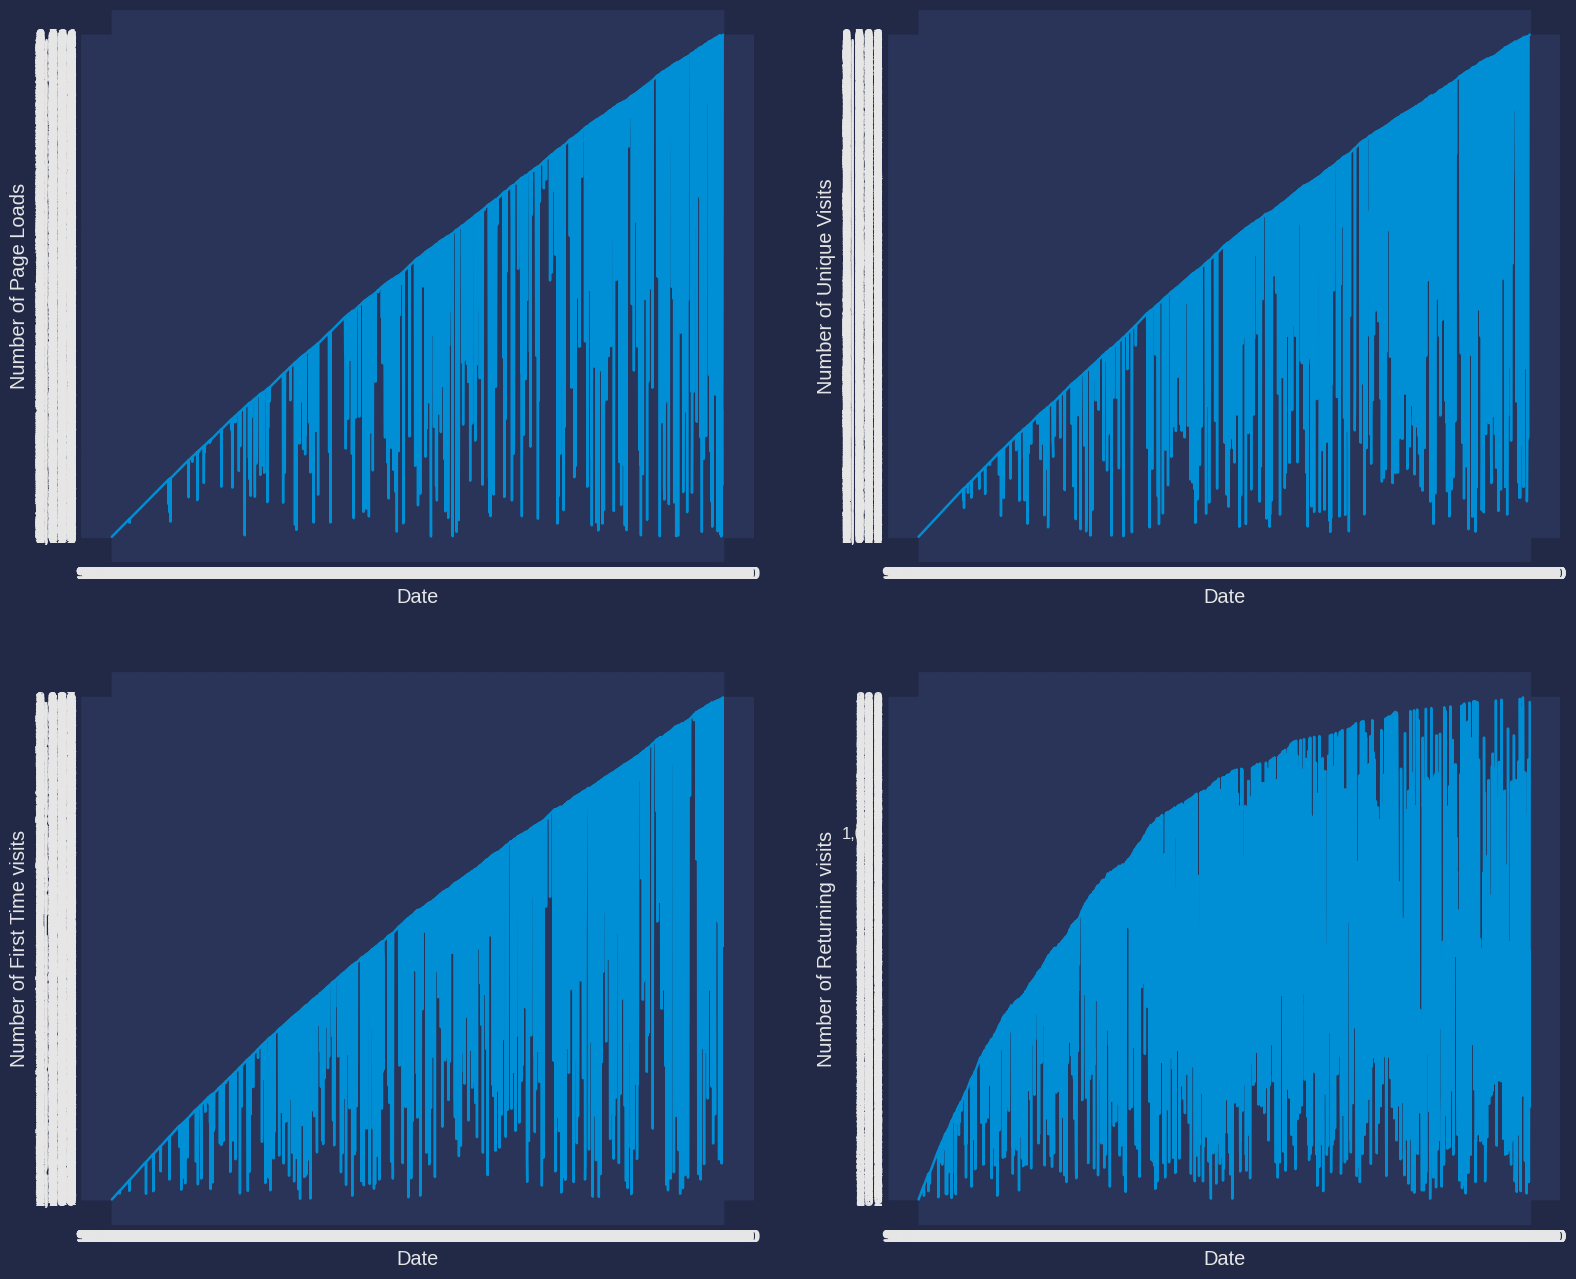

In [ ]:
data = pd.read_csv('/content/daily-website-visitors.csv')
figure, ax = plt.subplots(2, 2, figsize=(17, 15))
plt.style.use('seaborn')
ax1 = ax[0]
ax2 = ax[1]
ax1[0].plot(data['Date'], data['Page.Loads'])
ax1[0].set_xlabel("Date")
ax1[0].set_ylabel("Number of Page Loads")
ax1[1].plot(data['Date'], data['Unique.Visits'])
ax1[1].set_xlabel("Date")
ax1[1].set_ylabel("Number of Unique Visits")
ax2[0].plot(data['Date'], data['First.Time.Visits'])
ax2[0].set_xlabel("Date")
ax2[0].set_ylabel("Number of First Time visits")
ax2[1].plot(data['Date'], data['Returning.Visits'])
ax2[1].set_xlabel("Date")
ax2[1].set_ylabel("Number of Returning visits")

figure.show()

In [ ]:
def evaluate_performace(y_hist, y_true, y_pred, models):
    y_true = y_true.merge(y_pred, how="left", on=["unique_id", "ds"])
    evaluation = {}
    for model in models:
        evaluation[model] = {}
        for metric in [mae, mape, rmse, smape]:
            metric_name=metric.__name__
            evaluation[model][metric_name] = metric(y_true["y"].values, y_true[model].values)
    return pd.DataFrame(evaluation).T

In [ ]:
evaluate_performace(df_train, df_test, forecasts_test, models=["MSTL", "SeasonalNaive","SeasESOpt","TBATS"])


,mae,mape,rmse,smape
MSTL,198.812271,7.122421,348.106628,6.327327
SeasonalNaive,219.633331,7.504589,333.127441,6.895582
SeasESOpt,222.694397,7.616225,336.130920,6.988863
TBATS,286.671875,10.712254,419.691040,10.546618


#### Cross Validation

In [ ]:
crossvalidation_df = sf.cross_validation(
    df = df_train,
    h = 30,
    step_size = 24,
    n_windows = 3
  )

In [ ]:
crossvalidation_df

,ds,cutoff,y,MSTL,SeasonalNaive,OptimizedTheta,SeasESOpt,TBATS
unique_id,,,,,,,,
1,2020-05-04,2020-05-03,5939.0,5672.491699,6038.0,6350.093262,6036.618164,6851.419434
1,2020-05-05,2020-05-03,6361.0,5863.852051,6324.0,6464.632324,6317.075684,7016.597656
1,2020-05-06,2020-05-03,6659.0,5765.279297,6062.0,6402.151855,6059.227539,6942.822266
1,2020-05-07,2020-05-03,6264.0,5747.156250,5520.0,6143.601562,5574.741211,6626.924316
1,2020-05-08,2020-05-03,5359.0,5076.945312,4670.0,5195.814453,4696.071777,5444.653809
...,...,...,...,...,...,...,...,...
1,2020-07-16,2020-06-20,3756.0,4675.272461,4895.0,5002.891113,4858.890625,5174.728027
1,2020-07-17,2020-06-20,3289.0,3975.832275,3924.0,4060.087402,3985.480957,4183.040039
1,2020-07-18,2020-06-20,2416.0,3030.394287,2827.0,2830.930664,2828.426514,2834.637939


In [ ]:
models = ["MSTL", "SeasonalNaive", "OptimizedTheta", "SeasESOpt", "TBATS"]

metrics_dict = {"model": [], "mae": [], "mape": [], "rmse": [], "smape": []}

for model in models:
    # Calculate metrics
    mae_val = mae(crossvalidation_df["y"], crossvalidation_df[model])
    mape_val = mape(crossvalidation_df["y"], crossvalidation_df[model])
    rmse_val = rmse(crossvalidation_df["y"], crossvalidation_df[model])
    smape_val = smape(crossvalidation_df["y"], crossvalidation_df[model])
    metrics_dict["model"].append(model)
    metrics_dict["mae"].append(mae_val)
    metrics_dict["mape"].append(mape_val)
    metrics_dict["rmse"].append(rmse_val)
    metrics_dict["smape"].append(smape_val)

metrics_df = pd.DataFrame(metrics_dict).set_index("model")

In [ ]:
metrics_df

,mae,mape,rmse,smape
model,,,,
MSTL,537.984131,13.452978,618.774597,12.386517
SeasonalNaive,510.688904,12.611778,610.932129,11.642783
OptimizedTheta,663.143555,16.278276,815.242126,14.595570
SeasESOpt,522.352356,12.905134,620.317993,11.893082
TBATS,829.237732,19.781496,1031.851685,17.386313


# ***Conclusion***

* In this project, I successfully implemented multiple forecasting models to predict website traffic based on historical data. Through visualizations and performance metrics, we identified the strengths of each model in capturing traffic patterns, enabling us to make accurate forecasts. These predictions offer valuable insights for managing server resources and preparing for peak usage periods, contributing to improved website reliability and user experience. Overall, this forecasting approach provides a foundation for data-driven decisions in resource allocation, helping to ensure optimal performance and support for future growth.